# 1. Imports

In [1]:
# our functions
import functions as f
# readers

import gzip
import json

import codecs

import numpy as np

import random

# plot
import matplotlib.pyplot as plt
import scipy.stats as stats

# NN
## early stopping
import h5py
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# time


In [2]:
PATH = {}
PATH["dataset_classification"] = "dataset/classification/"
PATH["dataset_labeling"] = "dataset/seq_labeling/"
PATH["music_reviews_train"] = PATH["dataset_classification"] + "music_reviews_train.json.gz"
PATH["music_reviews_dev"] = PATH["dataset_classification"] + "music_reviews_dev.json.gz"
PATH["music_reviews_test"] = PATH["dataset_classification"] + "music_reviews_test_masked.json.gz"

# 2. Read in the files

In [3]:
train = f.readJson(PATH["music_reviews_train"])
dev = f.readJson(PATH["music_reviews_dev"])
test = f.readJson(PATH["music_reviews_test"])

Number of data:  100000
Number of data:  10000
Number of data:  10000


In [4]:
sent_dict = {"positive": 1, "negative": 0}

In [5]:
# read the train data
data = train
train_sent = []
train_sentiment = []
train_idx = []
missing_indexies = []
y_train = []
length_of_sentencies_counter = []
for i in range(len(data)):
    try:
        train_sent.append(data[i]["reviewText"])
        train_sentiment.append(data[i]["sentiment"])
        train_idx.append(i)
        y_train.append(sent_dict[data[i]["sentiment"]])
        length_of_sentencies_counter.append(len(data[i]["reviewText"].split()))
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

[4603, 4838, 16019, 18229, 19785, 23315, 28397, 28834, 33359, 43138, 43539, 43690, 44008, 44477, 44972, 48811, 49317, 50106, 51717, 52286, 55555, 56171, 57223, 58328, 58799, 58866, 59525, 59739, 61046, 61914, 61916, 62831, 63208, 72268, 78944, 79067, 80093, 80637, 80658, 81640, 81900, 82510, 83138, 83145, 83615, 84761, 87112, 88895, 88984, 89132, 91949, 94301, 94727, 99641]


number of words in the sentence
47.03345806735637


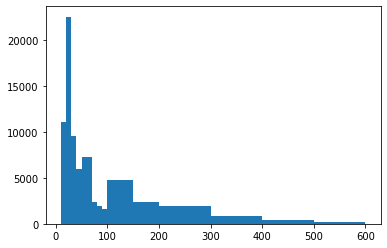

In [6]:
# train data reviews length simple statistic
import matplotlib.pyplot as plt
bins = [10, 20, 30,40,50,70,80,90,100,150,200,300,400,500,600]
plt.hist(length_of_sentencies_counter, bins = bins)
print("number of words in the sentence")
print(np.average(length_of_sentencies_counter))

In [7]:
data = dev
dev_sent = []
dev_sentiment = []
dev_idx = []
missing_indexies = []
dev_y_train = []
for i in range(len(data)):
    try:
        dev_sent.append(data[i]["reviewText"])
        dev_sentiment.append(data[i]["sentiment"])
        dev_idx.append(i)
        dev_y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        missing_indexies.append(i)
        continue
print(missing_indexies)

[2900, 4294, 5135, 8540]


In [8]:
data = test
test_sent = []
test_sentiment = []
test_idx = []
test_missing_indexies = []
#print(test)
for i in range(len(data)):
    try:
        test_sent.append(data[i]["reviewText"])
        test_sentiment.append(data[i]["sentiment"])
        print(data[i]["sentiment"])
        test_idx.append(i)
        #y_train.append(sent_dict[data[i]["sentiment"]]) 
    except KeyError:
        test_missing_indexies.append(i)
        continue
print("index of reviews which are empty: ",test_missing_indexies)

_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_


_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_


_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
_
index of reviews which are empty:  [90, 117, 439, 2138, 4112, 5364, 8210]


In [9]:
# it needs to be replaced since it doesnt handle the lower/upper cases and the mess
###################################################################################
from zeugma import TextsToSequences
sequencer = TextsToSequences()
sequencer.fit_transform(train_sent)
#print(sequencer.index_word)
# fit new data 
Train = sequencer.transform(train_sent)
Dev = sequencer.transform(dev_sent)
Test = sequencer.transform(test_sent)

c:\users\music\appdata\local\programs\python\python39\lib\site-packages\zeugma\keras_transformers.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(self.texts_to_sequences(texts))


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [11]:
def sequence_pad(sequence, padding='pre', maxlen=50):
    res = tf.keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=maxlen,
        dtype='int32',
        padding=padding,
        truncating='pre',
        value=0.0)
    return res

## Padding the dataset, POST padding works better a little bit

In [12]:
padding = "post"
maxlen = 50 # how many words from the review
X_train_p = sequence_pad(Train, padding=padding, maxlen=maxlen)
X_dev_p = sequence_pad(Dev, padding=padding, maxlen=maxlen)
X_test_p = sequence_pad(Test, padding=padding, maxlen=maxlen)
len(X_test_p)

9993

In [54]:
X_train_m = np.array(X_train_p)
y_train_m = np.array(y_train)
print(len(y_train_m))
print(len(X_train_m))
X_valid_m = np.array(X_dev_p)
y_valid_m = np.array(dev_y_train)
print(len(X_valid_m))
print(len(y_valid_m))
X_test_m = np.array(X_test_p)
#y_test_m = np.array(y_test)
print(len(X_test_m))
#print(len(y_test_m))

# sampling some random data for tran and DEV

bias = 10000

ran = random.randint(0, len(X_train_m)-bias)
ran_val = random.randint(0, len(X_valid_m)-(bias/10))
s_tr = ran
e = ran+bias
s_test = ran_val
e_test = ran_val+(bias/10)

X_train_m = X_train_m[s_tr:e]
y_train_m = y_train_m[s_tr:e]
X_valid_m = X_valid_m[s_test:int(e_test)]
y_valid_m = y_valid_m[s_test:int(e_test)]
#X_valid_m = X_valid_m[s:e]
#y_valid_m = y_valid_m[s:e]
print(len(y_train_m))
print(len(X_train_m))

99946
99946
9996
9996
9993
10000
10000


# Early stopping

In [14]:
# callback
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
#cb = Callback(...)
#cb_list = [cb, ...] # add the callback to a list
es = EarlyStopping(monitor='val_loss',
                  mode='min',
                  verbose=1,
                  patience=1) # to continue since maybe we get a local min somewhere'
                   
# es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1) # other possibility
# es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4) # based on threshold
# save best models
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)
checkpoint_filepath = 'model/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                             patience=3,
                                                             mode='min')

# checkpoint

'''model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='min',
    save_best_only=True)'''

"model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(\n    filepath=checkpoint_filepath,\n    save_weights_only=True,\n    monitor='val_accuracy',\n    mode='min',\n    save_best_only=True)"

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 64)            5119488   
                                                                 
 lstm_1 (LSTM)               (None, 100)               66000     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,185,589
Trainable params: 5,185,589
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
625/625 [==============================] - 47s 73ms/step - loss: 0.6317 - accuracy: 0.6538 - val_loss: 0.5659 - val_accuracy: 0.6920
Epoch 2/5
625/625 [==============================] - 44s 70ms/step - loss: 0.5647 - accuracy: 0.6824 - val_loss: 0.6906 - val_accuracy: 0.6010
Epoch 3/5
625/625

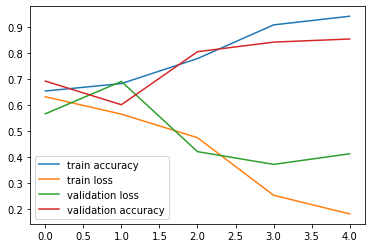

INFO:tensorflow:Assets written to: model/2022-3-24-11-51-51\assets


INFO:tensorflow:Assets written to: model/2022-3-24-11-51-51\assets


In [55]:
vocabulary_size = max(sequencer.index_word)

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# get time for saving the model

dateTimeObj = datetime.now()
save_time = str(dateTimeObj.year)+'-'+str(dateTimeObj.month)+'-'+str(dateTimeObj.day)+'-'+str(dateTimeObj.hour)+'-'+str(dateTimeObj.minute)+'-'+str(dateTimeObj.second)

# define the model

embedding_size=64
model=Sequential()
model.add(Embedding(vocabulary_size+1, embedding_size, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

print(model.summary())

batch_size = 16
num_epochs = 5

#X_valid, y_valid = X_train_k[batch_size:], y_train[batch_size:]
history = model.fit(X_train_m, y_train_m, validation_data=(X_valid_m, y_valid_m), 
                    batch_size=batch_size, 
                    epochs=num_epochs)  # for regularization)
#history = model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_trainn, y_trainn, batch_size=batch_size, epochs=num_epochs)
#model.fit(X_train_m, y_train_m, batch_size=batch_size, epochs=num_epochs)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
plt.plot(history.history["accuracy"], label='train accuracy')
plt.plot(history.history["loss"], label='train loss')
plt.plot(history.history["val_loss"], label='validation loss')
plt.plot(history.history["val_accuracy"], label='validation accuracy')
plt.legend()
plt.show()
######### ------------------------- ################### save the model
model.save('model/'+save_time)

### Save the model, prediction

In [57]:
#model.save('model/')
result = model.predict(X_test_m)

## Sentiment results, Sampling some guess

In [59]:
threshold = 0.5
acc = 0
acc_count = 0
res_final = []
for r in result:
    acc_count+=1
    if r<threshold:
        r = 0
        res_final.append("negative")
    if r>threshold:
        res_final.append("positive")
        
for i in random.sample(range(0, 9993), 5):
    print("index", i)
    print("####", res_final[i], "---", test_sent[i])

index 5748
#### negative --- The song sucks and it's way overplayed.
The best music I ever heard doesn't get airplay you have to find it.
Taylor swift isn't one of them.
index 1319
#### negative --- live version & doesn't have his woman counterpart
index 2671
#### positive --- You will probably like this too. Very humorous lyrics, as is usual for any ERB or Rhett and Link song.
index 8544
#### negative --- I was looking for the ORIGINAL main title theme and the only thing I could find is this poorly put together, tacky, horrible sounding electronic remix version. I'm sorry but I'm disappointed. Amazon needs to find the original and out it out there for us to buy. Do not buy.
index 4847
#### positive --- Loved this CD.  First heard it on satellite radio and hunted it down.  It met all my expectations and more so.


In [21]:
from collections import defaultdict

json_raw_data = []
jsonfilename = 'dataset/classification/tt.gz'
counter = 0
list_of_skip_indexies = [90, 117, 439, 2138, 4112, 5364, 8210]
res_count = 0
for line in gzip.open('dataset/classification/t_masked.gz'):
    review_data = json.loads(line)
    tempdata = []
    if counter in list_of_skip_indexies: # keep origine
        print("keep original")
        print(counter)
        print(review_data)
        res_count -=1
        for key in review_data:
            #print("keep original")
            tempdata.append({
            key: str(review_data[key])})
    else:
        def_dict = defaultdict(list)
        def_dict = dict()
        for key in review_data:
            #print(key)
            if key == "sentiment":
                def_dict[key] = res_final[res_count]
            else:
                tempdata.append({
                key: str(review_data[key])})
                def_dict[key] = str(review_data[key])
    counter += 1
    res_count +=1
    #print(counter)

    #json_raw_data.append(def_dict)
    json_raw_data.append(def_dict) # ok this is very good, itsa opening with json.load
    
outFile = open('music_reviews_test.json', 'w')
for instance in json_raw_data:
      outFile.write(json.dumps(instance) + '\n')
outFile.close()

keep original
90
{'verified': False, 'reviewTime': '11 16, 2015', 'reviewerID': 'A1O7C6DFZ15E43', 'asin': 'B007Z2OQB0', 'summary': 'Five Stars', 'unixReviewTime': 1447632000, 'sentiment': '_', 'id': 90}
keep original
117
{'verified': True, 'reviewTime': '07 31, 2017', 'reviewerID': 'AWGJYHMXOYCVI', 'asin': 'B007ZCH8R4', 'unixReviewTime': 1501459200, 'sentiment': '_', 'id': 117}
keep original
439
{'verified': True, 'reviewTime': '08 16, 2016', 'reviewerID': 'A24YYQXR82CKHJ', 'asin': 'B008591TBW', 'style': {'Format:': ' MP3 Music'}, 'summary': 'Five Stars', 'unixReviewTime': 1471305600, 'sentiment': '_', 'id': 439}
keep original
2138
{'verified': True, 'reviewTime': '09 13, 2016', 'reviewerID': 'A1ZBIIZLWE8NRE', 'asin': 'B00940XFTK', 'style': {'Format:': ' MP3 Music'}, 'summary': 'Five Stars', 'unixReviewTime': 1473724800, 'sentiment': '_', 'id': 2138}
keep original
4112
{'verified': True, 'reviewTime': '07 4, 2018', 'reviewerID': 'A1K51YDXUGEEBG', 'asin': 'B000YIWSK8', 'unixReviewTime':

In [20]:
for line in gzip.open('group16.json.gz'):
    review_data = json.loads(line)
    for key in review_data:
        print('"' + key +'": ' + str(review_data[key]))
    break

"verified": True
"reviewTime": 10 24, 2017
"reviewerID": A2HAJB8L9NVYTZ
"asin": B007Y1AMHE
"reviewText": ok
"summary": ok
"unixReviewTime": 1508803200
"sentiment": negative
"id": 0
